In [2]:
# Installing and importing the necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from itertools import permutations
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, ClassicalRegister, QuantumRegister, execute
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals, QuantumInstance

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

{(0, 1): Text(0.5, 1.0, '5'),
 (0, 3): Text(0.0, 0.5, '5'),
 (0, 2): Text(0.5, 0.5, '2'),
 (1, 2): Text(1.0, 0.5, '5'),
 (1, 3): Text(0.5, 0.5, '2'),
 (2, 3): Text(0.5, 0.0, '5')}

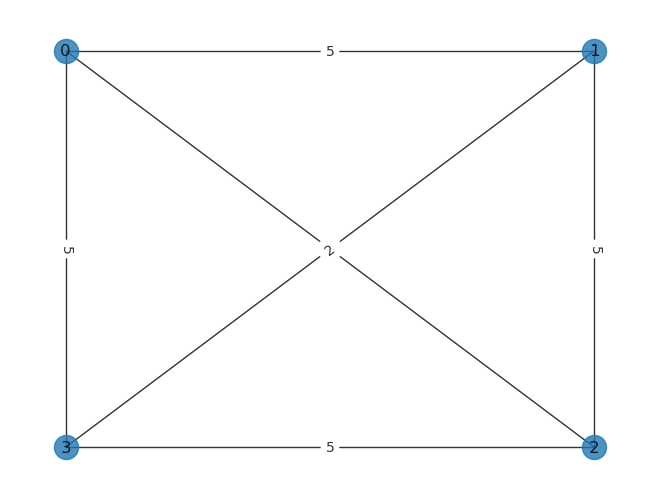

In [3]:
# Below we create the graph formulation of our Travelling Salesman Problem (TSP) instance.

G = nx.Graph()
G.add_node(0,pos=(0,1))
G.add_node(1,pos=(1,1))
G.add_node(2,pos=(1,0))
G.add_node(3,pos=(0,0))

G.add_edge(0, 1, weight=5)
G.add_edge(1, 2, weight=5)
G.add_edge(2, 3, weight=5)
G.add_edge(3, 0, weight=5)
G.add_edge(0, 2, weight=2)
G.add_edge(1, 3, weight=2)

pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, alpha=0.8, pos=pos, edge_labels=labels)

In [4]:
num_nodes = 4 
adj_matrix = nx.adjacency_matrix(G).todense()
num_qubits = num_nodes ** 2

/tmp/ipykernel_4574/791945573.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).todense()


order = (0, 1, 2, 3) Distance = 20
order = (0, 1, 3, 2) Distance = 14
Best order from brute force = (0, 1, 3, 2) with total distance = 14


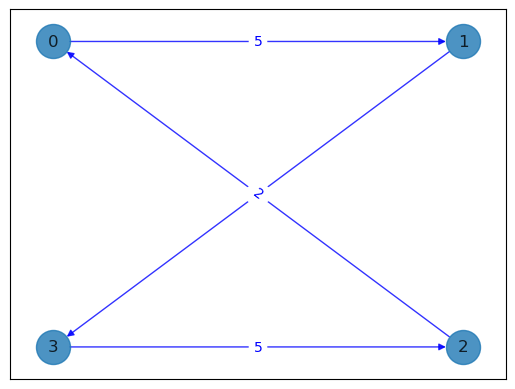

In [5]:
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, num_nodes)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

tsp = Tsp(G)
draw_tsp_solution(tsp.graph, best_order, pos)

In [6]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  5*x_0_0*x_1_1 + 5*x_0_0*x_1_3 + 2*x_0_0*x_2_1 + 2*x_0_0*x_2_3 + 5*x_0_0*x_3_1
  + 5*x_0_0*x_3_3 + 5*x_0_1*x_1_0 + 5*x_0_1*x_1_2 + 2*x_0_1*x_2_0
  + 2*x_0_1*x_2_2 + 5*x_0_1*x_3_0 + 5*x_0_1*x_3_2 + 5*x_0_2*x_1_1
  + 5*x_0_2*x_1_3 + 2*x_0_2*x_2_1 + 2*x_0_2*x_2_3 + 5*x_0_2*x_3_1
  + 5*x_0_2*x_3_3 + 5*x_0_3*x_1_0 + 5*x_0_3*x_1_2 + 2*x_0_3*x_2_0
  + 2*x_0_3*x_2_2 + 5*x_0_3*x_3_0 + 5*x_0_3*x_3_2 + 5*x_1_0*x_2_1
  + 5*x_1_0*x_2_3 + 2*x_1_0*x_3_1 + 2*x_1_0*x_3_3 + 5*x_1_1*x_2_0
  + 5*x_1_1*x_2_2 + 2*x_1_1*x_3_0 + 2*x_1_1*x_3_2 + 5*x_1_2*x_2_1
  + 5*x_1_2*x_2_3 + 2*x_1_2*x_3_1 + 2*x_1_2*x_3_3 + 5*x_1_3*x_2_0
  + 5*x_1_3*x_2_2 + 2*x_1_3*x_3_0 + 2*x_1_3*x_3_2 + 5*x_2_0*x_3_1
  + 5*x_2_0*x_3_3 + 5*x_2_1*x_3_0 + 5*x_2_1*x_3_2 + 5*x_2_2*x_3_1
  + 5*x_2_2*x_3_3 + 5*x_2_3*x_3_0 + 5*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 + x_2_3 == 1  'c2'
    x_3_0 

In [7]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 3136.0
Ising Hamiltonian:
-392.0 * IIIIIIIIIIIIIIIZ
- 392.0 * IIIIIIIIIIIIIIZI
- 392.0 * IIIIIIIIIIIIIZII
- 392.0 * IIIIIIIIIIIIZIII
- 392.0 * IIIIIIIIIIIZIIII
- 392.0 * IIIIIIIIIIZIIIII
- 392.0 * IIIIIIIIIZIIIIII
- 392.0 * IIIIIIIIZIIIIIII
- 392.0 * IIIIIIIZIIIIIIII
- 392.0 * IIIIIIZIIIIIIIII
- 392.0 * IIIIIZIIIIIIIIII
- 392.0 * IIIIZIIIIIIIIIII
- 392.0 * IIIZIIIIIIIIIIII
- 392.0 * IIZIIIIIIIIIIIII
- 392.0 * IZIIIIIIIIIIIIII
- 392.0 * ZIIIIIIIIIIIIIII
+ 96.5 * IIIIIIIIIIIIIIZZ
+ 96.5 * IIIIIIIIIIIIIZIZ
+ 96.5 * IIIIIIIIIIIIIZZI
+ 96.5 * IIIIIIIIIIIIZIIZ
+ 96.5 * IIIIIIIIIIIIZIZI
+ 96.5 * IIIIIIIIIIIIZZII
+ 96.5 * IIIIIIIIIIIZIIIZ
+ 1.25 * IIIIIIIIIIIZIIZI
+ 1.25 * IIIIIIIIIIIZZIII
+ 1.25 * IIIIIIIIIIZIIIIZ
+ 96.5 * IIIIIIIIIIZIIIZI
+ 1.25 * IIIIIIIIIIZIIZII
+ 96.5 * IIIIIIIIIIZZIIII
+ 1.25 * IIIIIIIIIZIIIIZI
+ 96.5 * IIIIIIIIIZIIIZII
+ 1.25 * IIIIIIIIIZIIZIII
+ 96.5 * IIIIIIIIIZIZIIII
+ 96.5 * IIIIIIIIIZZIIIII
+ 1.25 * IIIIIIIIZIIIIIIZ
+ 1.25 * IIIIIIIIZIIIIZII
+ 96.5 * IIIIII

In [ ]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

In [ ]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("Energy:", result.eigenvalue.real)
print("TSP objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("Feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("Solution:", z)
print("Solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, pos)

In [ ]:
algorithm_globals.random_seed = 12345
seed = 0
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

spsa = SPSA(maxiter=100)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=1, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, pos)

Inspiration:

https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html#Traveling-Salesman-Problem

https://arxiv.org/pdf/1302.5843.pdf

